##Set Up

In [ ]:
!pip install keras-preprocessing
!pip install -q kaggle

from IPython.display import clear_output
clear_output()

In [ ]:
import numpy as np
np.random.seed(345)

from tensorflow.random import set_seed
set_seed(3)

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import confusion_matrix
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d landrykezebou/vcor-vehicle-color-recognition-dataset
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!kaggle datasets download -d rrighart/vcor-annot-errors

 99% 568M/574M [00:07<00:00, 118MB/s]
100% 574M/574M [00:07<00:00, 77.4MB/s]
 98% 555M/565M [00:06<00:00, 165MB/s]
100% 565M/565M [00:06<00:00, 91.8MB/s]
  0% 0.00/767 [00:00<?, ?B/s]
100% 767/767 [00:00<00:00, 1.35MB/s]


In [ ]:
!unzip /content/vcor-vehicle-color-recognition-dataset.zip -d /content/dataset
!unzip /content/fashion-product-images-small.zip -d /content/dataset1
!unzip /content/vcor-annot-errors.zip -d /content/dataset2

clear_output()

##Prepare

In [ ]:
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/val/'
test_dir = '/content/dataset/test/'
inference_dir = '/content/dataset1/images'
annotation_error_file = '/content/dataset2/annotation-error.txt'

In [ ]:
def count_images(dataset):
    image_counts = [len(os.listdir(os.path.join(dataset, i))) for i in sorted(os.listdir(dataset))]
    return pd.DataFrame({'color': sorted(os.listdir(dataset)), 'count': image_counts})

In [ ]:
def create_dataframe(sourcedir, removal_files, textdir):
    # Implement your logic for creating DataFrames here
    coll_labelnames = []
    coll_idfiles = []

    for i in os.listdir(sourcedir):
        idfiles = os.listdir(os.path.join(sourcedir, i))
        labelnames = len(idfiles) * [str(i)]
        coll_labelnames.append(labelnames)
        coll_idfiles.append(idfiles)

    df = pd.DataFrame({'label': [item for sublist in coll_labelnames for item in sublist],
                       'idfiles': [item for sublist in coll_idfiles for item in sublist]})
    df['id'] = str(sourcedir) + df['label'] + '/' + df['idfiles']

    if removal_files == 'yes':
        with open(textdir) as f:
            files_to_remove = f.read().splitlines()
        files_to_remove = list(filter(lambda x: 'jpg' in x, files_to_remove))
        df = df[~df['idfiles'].isin(files_to_remove)]

    return df

In [ ]:
def build_model(input_shape, num_classes):
    """
    Build and compile the classification model.
    """
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape, pooling='max')
    x = base_model.output
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate=0.45, seed=123)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizers.Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
train_image_counts = count_images(train_dir)

In [ ]:
train_image_counts

,color,count
0,beige,421
1,black,406
2,blue,742
3,brown,565
4,gold,210
5,green,563
6,grey,428
7,orange,534
8,pink,483
9,purple,536


In [ ]:
# Other parameters
image_size = 224
class_subset = sorted(os.listdir(train_dir))
num_classes = len(class_subset)
batch_size = 32
num_epochs = 128

##Create Model

In [ ]:
model = build_model((image_size, image_size, 3), num_classes)
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

##Prepare Data

In [ ]:
train_dataframe = create_dataframe(train_dir, 'yes', annotation_error_file)
valid_dataframe = create_dataframe(val_dir, 'yes', annotation_error_file)

train_generator = ImageDataGenerator(rescale=1/255., width_shift_range=0.5, rotation_range=False, horizontal_flip=True)
valid_generator = ImageDataGenerator(rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1./255.)

traingen = train_generator.flow_from_dataframe(dataframe=train_dataframe, directory=None, x_col="id", y_col="label",
                                              subset="training", batch_size=batch_size, shuffle=True,
                                              class_mode="categorical", target_size=(image_size, image_size))

validgen = valid_generator.flow_from_dataframe(dataframe=valid_dataframe, directory=None, x_col="id", y_col="label",
                                              subset="training", batch_size=batch_size, shuffle=True,
                                              class_mode="categorical", target_size=(image_size, image_size))

Found 7202 validated image filenames belonging to 15 classes.
Found 1550 validated image filenames belonging to 15 classes.


##Train

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='EFN-model.best.h5', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True, mode='min'),
    CSVLogger('training.log', separator=',', append=False)
]

In [ ]:
train_steps = traingen.samples // batch_size
valid_steps = validgen.samples // batch_size

history = model.fit(
    traingen,
    epochs=num_epochs,
    steps_per_epoch=train_steps,
    validation_data=validgen,
    validation_steps=valid_steps,
    callbacks=callbacks,
    verbose=1,
    shuffle=True,
    workers=4
)

Epoch 1/128
225/225 [==============================] - ETA: 0s - loss: 2.8409 - accuracy: 0.2250
Epoch 1: val_loss improved from inf to 5.06716, saving model to EFN-model.best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 207s 617ms/step - loss: 2.8409 - accuracy: 0.2250 - val_loss: 5.0672 - val_accuracy: 0.0859
Epoch 2/128
225/225 [==============================] - ETA: 0s - loss: 1.6057 - accuracy: 0.5039
Epoch 2: val_loss improved from 5.06716 to 2.69390, saving model to EFN-model.best.h5
225/225 [==============================] - 140s 611ms/step - loss: 1.6057 - accuracy: 0.5039 - val_loss: 2.6939 - val_accuracy: 0.2389
Epoch 3/128
225/225 [==============================] - ETA: 0s - loss: 1.2867 - accuracy: 0.5865
Epoch 3: val_loss improved from 2.69390 to 1.18340, saving model to EFN-model.best.h5
225/225 [==============================] - 136s 600ms/step - loss: 1.2867 - accuracy: 0.5865 - val_loss: 1.1834 - val_accuracy: 0.6068
Epoch 4/128
225/225 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.6319
Epoch 4: val_loss improved from 1.18340 to 0.79283, saving model to EFN-model.best.h5
225/225 [==============================] - 140

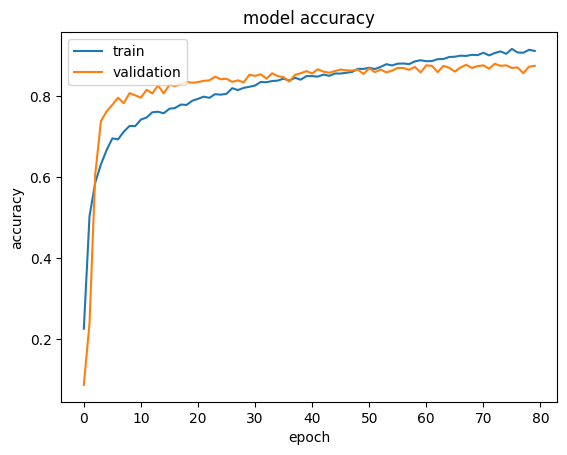

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Export Model

In [ ]:
model.save_weights("model_weights.h5")
model.save("full_model.h5")

In [ ]:
from keras.models import load_model

# Load model
loaded_model = tf.keras.models.load_model("full_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Export to TFLite Format
with open('model1.tflite', 'wb') as f:
    f.write(tflite_model)

# Export to JSON Format
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)


##Test Model

In [ ]:
class_subset = sorted(os.listdir(test_dir))
test_generator = ImageDataGenerator(rescale=1./255)

testgen = test_generator.flow_from_directory(test_dir,
                                               target_size=(image_size, image_size),
                                               batch_size=1,
                                               class_mode=None,
                                               classes=class_subset,
                                               shuffle=False
                                               )

model_predict = model.predict(testgen)

In [ ]:
predicted_classes = np.argmax(model_predict, axis=-1) #model.predict_classes(testgen). Argmax returns indices of max values
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [ ]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))
    fig.savefig('testgallery.png')

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

##Run Prediction

In [ ]:
from numpy import asarray

def color_tag(sourcedir, imin, image_size, thr):

    image = tf.keras.preprocessing.image.load_img(os.path.join(sourcedir, imin), target_size=(image_size, image_size))
    data = asarray(image)
    ndata = np.expand_dims(data, axis=0)
    y_prob = model.predict(ndata/255)
    y_prob.argmax(axis=-1)

    print('color', [sorted(os.listdir(train_dir))[i] for i in np.where(np.ravel(y_prob)>thr)[0]])
    print('values', [np.ravel(y_prob)[i] for i in list(np.where(np.ravel(y_prob)>thr)[0])])

##Save to GDrive

In [ ]:
!cp /content/full_model.h5 /content/drive/MyDrive/newmodels/color_v1/full_model.h5
!cp /content/model_weights.h5 /content/drive/MyDrive/newmodels/color_v1/model_weights.h5
!cp /content/model1.tflite /content/drive/MyDrive/newmodels/color_v1/model1.tflite

<h1>Finish</h1>

[click here](https://drive.google.com/drive/folders/11xABDsvqFXp2tirw_jPYxGXNUQaebBJi) to open Google Drive folder

##Test Model

<p>Example 1</p>

In [ ]:
# !cp /content/drive/MyDrive/newmodels/color_v1/full_model.h5 /content/full_model.h5

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def color_tag(model, image_path, target_size, threshold):
    try:
        image = load_img(image_path, target_size=target_size)
        data = img_to_array(image)
        ndata = np.expand_dims(data, axis=0)

        # Normalize data before prediction
        normalized_data = ndata / 255

        y_prob = model.predict(normalized_data)
        flattened_prob = np.ravel(y_prob)

        # Get indices where probability is above threshold
        indices_above_threshold = np.where(flattened_prob > threshold)[0]

        # Get colors and values based on indices
        colors = [sorted(os.listdir(train_dir))[i] for i in indices_above_threshold]
        values = [flattened_prob[i] for i in indices_above_threshold]

        return colors, values

    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Load the model
model = tf.keras.models.load_model("/content/full_model.h5")

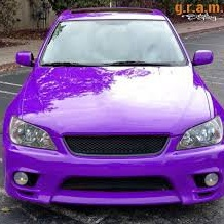

In [ ]:
image_path = '/content/dataset/test/purple/1755c49ed5.jpg'
isize = (224, 224)

tf.keras.preprocessing.image.load_img(image_path, target_size=isize)

In [ ]:
predicted_colors, predicted_values = color_tag(model, image_path, isize, 0.1)

if predicted_colors and predicted_values:
    print('Color:', predicted_colors)
    print('Values:', predicted_values)

1/1 [==============================] - 0s 149ms/step
Color: ['purple']
Values: [0.9596086]


<p>Example 2</p>

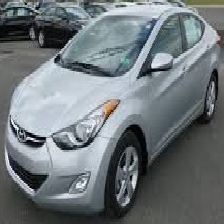

In [ ]:
image_path = '/content/dataset/test/silver/1c80e5b519.jpg'
isize = (224, 224)

tf.keras.preprocessing.image.load_img(image_path, target_size=isize)

In [ ]:
predicted_colors, predicted_values = color_tag(model, image_path, isize, 0.1)

if predicted_colors and predicted_values:
    print('Color:', predicted_colors)
    print('Values:', predicted_values)

1/1 [==============================] - 1s 523ms/step
Color: ['silver']
Values: [0.8771335]


<p>Example 3</p>

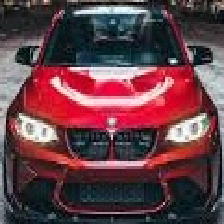

In [ ]:
image_path = '/content/dataset/test/red/1637b33e56.jpg'
isize = (224, 224)

tf.keras.preprocessing.image.load_img(image_path, target_size=isize)

In [ ]:
predicted_colors, predicted_values = color_tag(model, image_path, isize, 0.1)

if predicted_colors and predicted_values:
    print('Color:', predicted_colors)
    print('Values:', predicted_values)

1/1 [==============================] - 0s 171ms/step
Color: ['red']
Values: [0.9695238]
